# Lab Part 1 - Steam Analysis

In [1]:
# standard library imports
import itertools
import re
import math

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()
# sns.set() # default seaborn style

In [2]:
df = pd.read_csv(
    filepath_or_buffer = 'datasets/steam/steam.csv',sep=',', decimal = ".", )
list(df.columns) 

['appid',
 'name',
 'release_date',
 'english',
 'developer',
 'publisher',
 'platforms',
 'required_age',
 'categories',
 'genres',
 'steamspy_tags',
 'achievements',
 'positive_ratings',
 'negative_ratings',
 'average_playtime',
 'median_playtime',
 'owners',
 'price']

In [3]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [4]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


In [5]:
get_unique(df['categories'])
get_unique(df['genres'])
get_unique(df['platforms'])
get_unique(df['steamspy_tags'])



{'1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '360 Video',
 '3D',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Assassin',
 'Atmospheric',
 'Audio Production',
 'BMX',
 'Base-Building',
 'Baseball',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Cats',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-op',
 'Cold War',
 'Colorful',
 'Comedy',
 'Comic Book',
 'Competitive',
 'Controller',
 'Conversation',
 'Crafting',
 '

In [6]:
def process_cat_gen_tag(df):
    """Process categories, genres, steamspy_tags and platform columns."""
    # get all unique plattform names
    plat_cols = get_unique(df['platforms'])
    
    # create a new column for each platform, with 1s indicating membership and 0s for non-members
    for col in sorted(plat_cols):
        plat_name = re.sub(r'[\s\-\/]', '_', col.lower())
        plat_name = re.sub(r'[()]', '', plat_name)
        
        df[plat_name] = df['platforms'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])  
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    tag_cols = get_unique(df['steamspy_tags'])
    df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags','platforms'], axis=1)
    
    return df

In [7]:
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

In [8]:
def pre_process():
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd.read_csv(filepath_or_buffer = 'datasets/steam/steam.csv',sep=',', decimal = ".")
    
    # keep lower and higher bound of owners column, as integer
    df['owners_low_bound'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    df['owners_high_bound'] = df['owners'].str.split('-').apply(lambda x: x[1]).astype(int)
    del df['owners']
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    # Create a column to split free vs paid games
    df['type'] = 'Free'
    df.loc[df['price'] > 0, 'type'] = 'Paid'
    
    # Add Value total playtime
    df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)

    # Add Value total playtime
    df['estimated_revenue'] = df.apply (lambda row: row.price*row.owners_low_bound, axis=1)

    return df

In [9]:
processedDF = pre_process()
pDF = processedDF 

In [10]:
processedDF.head()

,appid,name,release_date,english,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,captions_available,co_op,commentary_available,cross_platform_multiplayer,full_controller_support,in_app_purchases,includes_source_sdk,includes_level_editor,local_co_op,local_multi_player,mmo,mods,mods_require_hl2,multi_player,online_co_op,online_multi_player,partial_controller_support,shared_split_screen,single_player,stats,steam_achievements,steam_cloud,steam_leaderboards,steam_trading_cards,steam_turn_notifications,steam_workshop,steamvr_collectibles,vr_support,valve_anti_cheat_enabled,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,top_tag,type,total_playtime,estimated_revenue
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Action,0,124534,3339,17612,317,7.19,10000000,20000000,127873,0.973888,95.975678,2000,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Paid,176120000000,71900000.0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,Action,0,3318,633,277,62,3.99,5000000,10000000,3951,0.839787,80.508259,1999,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Paid,1385000000,19950000.0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,Action,0,3416,398,187,34,3.99,5000000,10000000,3814,0.895648,85.823915,2003,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FPS,Paid,935000000,19950000.0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,0,Action,0,1273,267,258,184,3.99,5000000,10000000,1540,0.826623,78.126542,2001,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Paid,1290000000,19950000.0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,0,Action,0,5250,288,624,415,3.99,5000000,10000000,5538,0.947996,91.260480,1999,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FPS,Paid,3120000000,19950000.0


In [11]:
list(processedDF.columns) 
processedDF.shape

(27075, 85)

In [12]:
processedDF.describe()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,captions_available,co_op,commentary_available,cross_platform_multiplayer,full_controller_support,in_app_purchases,includes_source_sdk,includes_level_editor,local_co_op,local_multi_player,mmo,mods,mods_require_hl2,multi_player,online_co_op,online_multi_player,partial_controller_support,shared_split_screen,single_player,stats,steam_achievements,steam_cloud,steam_leaderboards,steam_trading_cards,steam_turn_notifications,steam_workshop,steamvr_collectibles,vr_support,valve_anti_cheat_enabled,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,total_playtime,estimated_revenue
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000,2.707500e+04,2.707500e+04,2.707500e+04,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.00000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,27075.000000,2.707500e+04,2.707500e+04
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193,8.012669e+04,1.880543e+05,1.211586e+03,0.714478,58.830540,2016.498098,0.193352,0.297913,0.999815,0.026630,0.063564,0.005319,0.039926,0.210342,0.025485,0.001293,0.038264,0.039114,0.059649,0.015549,0.000074,0.000037,0.146777,0.039557,0.091856,0.156380,0.079483,0.948403,0.069363,0.521884,0.266630,0.127018,0.292447,0.002327,0.03313,0.001477,0.008532,0.003472,0.000222,0.439631,0.370526,0.002918,0.001071,0.377101,0.003213,0.000037,0.109104,0.001884,0.062936,0.000628,0.019834,0.717304,0.026704,0.009825,0.000443,0.159224,0.037821,0.009049,0.191837,0.001145,0.048827,0.193795,0.000037,0.005392,0.001404,0.031136,0.001034,2.886696e+08,6.953147e+05
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922,8.708977e+05,1.786801e+06,2.242909e+04,0.233594,20.100043,2.156990,0.394934,0.457350,0.013588,0.161002,0.243979,0.072736,0.195789,0.407559,0.157595,0.035932,0.191837,0.193869,0.236840,0.123726,0.008595,0.006077,0.353890,0.194919,0.288828,0.363222,0.270496,0.221217,0.254075,0.499530,0.442205,0.332999,0.454895,0.048182,0.17898,0.038409,0.091975,0.058821,0.014885,0.496351,0.482955,0.053939,0.032711,0.484669,0.056596,0.006077,0.311776,0.043361,0.242853,0.025050,0.139431,0.450318,0.161219,0.098633,0.021048,0.365892,0.190766,0.094696,0.393753,0.033819,0.215511,0.395277,0.006077,0.073236,0.037438,0.173688,0.032142,1.767700e+10,9.673244e+06
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000e+00,2.000000e+04,1.000000e+00,0.000000,0.000000,1997.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [13]:
# Filter Games mit wenig Usernb

<AxesSubplot:>

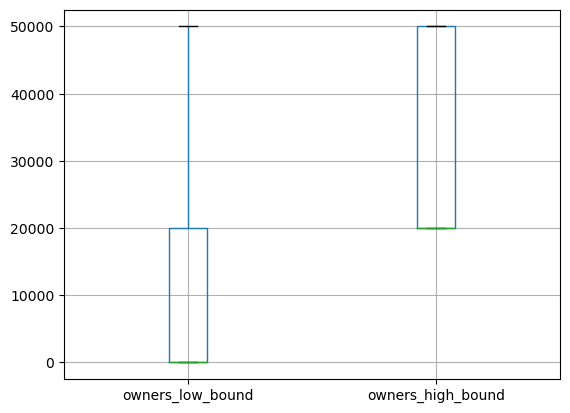

In [14]:
pDF.boxplot(column=['owners_low_bound','owners_high_bound'], return_type='axes',showfliers=False)

In [15]:
#indexNames = pDF[ pDF['owners_low_bound'] < 5000 ].index
# Delete these row indexes from dataFrame
#pDF.drop(indexNames , inplace=True)
#len(indexNames)

In [16]:
pDF.shape

(27075, 85)

Text(0.5, 1.0, 'Combination median_playtime,owners_low_bound ')

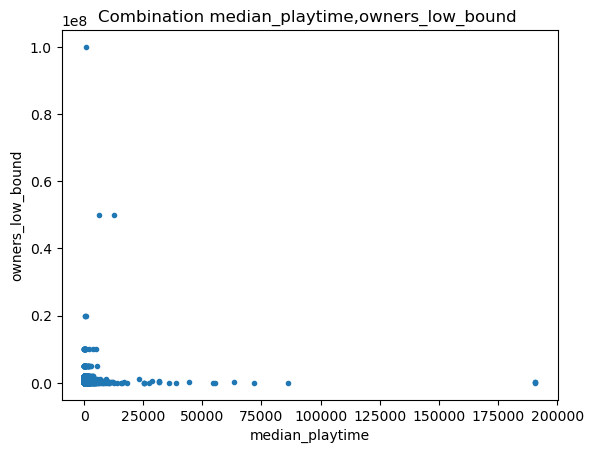

In [17]:
#Unterschied playtime vs price
xCol = 'median_playtime'
yCol = 'owners_low_bound' 


color =  np.array(['red','blue'])
plt.scatter(marker='.',x=pDF[xCol],y=pDF[yCol])
plt.xlabel(xCol)
plt.ylabel(yCol)
plt.title('Combination '+xCol+','+yCol +' ')


In [18]:
processedDF.sort_values(by='median_playtime',ascending=False)

,appid,name,release_date,english,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,captions_available,co_op,commentary_available,cross_platform_multiplayer,full_controller_support,in_app_purchases,includes_source_sdk,includes_level_editor,local_co_op,local_multi_player,mmo,mods,mods_require_hl2,multi_player,online_co_op,online_multi_player,partial_controller_support,shared_split_screen,single_player,stats,steam_achievements,steam_cloud,steam_leaderboards,steam_trading_cards,steam_turn_notifications,steam_workshop,steamvr_collectibles,vr_support,valve_anti_cheat_enabled,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,top_tag,type,total_playtime,estimated_revenue
9201,474030,The Abbey of Crime Extensum,2016-05-19,1,Manuel Pazos;Daniel Celemín,Manuel Pazos;Daniel Celemín,0,Adventure;Free to Play,0,146,22,190625,190625,0.00,50000,100000,168,0.869048,77.628930,2016,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Free to Play,Free,9531250000,0.0
1478,219340,The Banner Saga: Factions,2013-02-25,1,Stoic,Versus Evil,0,Free to Play;Indie;RPG;Strategy,42,569,202,95245,190489,0.00,200000,500000,771,0.738003,68.814073,2013,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Free to Play,Free,19049000000,0.0
6014,380140,The Secret of Tremendous Corporation,2015-10-12,1,Sebastian Krzyszkowiak;Konrad Burandt;Paweł Radej,dosowisko.net,0,Adventure;Casual;Free to Play;Indie,0,218,50,95242,190445,0.00,100000,200000,268,0.813433,73.794736,2015,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Free to Play,Free,9524200000,0.0
2023,252690,Fantasy Grounds,2014-05-09,1,"SmiteWorks USA, LLC","SmiteWorks USA, LLC",0,Indie;RPG;Strategy,0,377,100,43074,86148,29.99,20000,50000,477,0.790356,72.866781,2014,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,RPG,Paid,861480000,599800.0
23409,892420,懒人修仙传,2018-11-14,0,托更的修罗,托更的修罗,0,Casual;Indie;RPG;Simulation,0,404,164,43632,71857,2.89,20000,50000,568,0.711268,65.858932,2018,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,Simulation,Paid,872640000,57800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,553450,The Purge Day,2016-11-25,1,Red Limb Studio,Red Limb Studio,0,Violent;Action;Indie,14,22,16,0,0,1.99,0,20000,38,0.578947,48.286340,2016,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Indie,Paid,0,0.0
11912,553440,R.A.T.S. (Regulatory Astro-Topographical Stabi...,2017-02-15,1,Mark Miller Studios,I.E.D. Studios,0,Action;Indie,9,9,2,0,0,0.00,0,20000,11,0.818182,62.456017,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Free,0,0.0
11911,553430,Skill Master VR -- Learn Meditation,2016-11-21,1,fletcher.richman;owockitalki,Boulder VR Studios,0,Indie;Early Access,9,3,2,0,0,10.99,0,20000,5,0.600000,42.506594,2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
processedDF['owners_low_bound'].median()

0.0

## Top played games
Get the top x% of Games based on User

In [20]:
percent = 50
pDF.sort_values(by='owners_low_bound',ascending=False)
numberOfTopGames = math.ceil(len(pDF.index) * percent / 100 )
print("total number",len(pDF.index))
print("top",percent,"%",numberOfTopGames)


total number 27075
top 50 % 13538


In [21]:
topPDF = pDF.sort_values(by='owners_low_bound',ascending=False).head(numberOfTopGames)

In [22]:
#topPDF

In [23]:
def scatterPlot(df,xCol,yCol,color):
    color =  np.array(['red','blue'])
    plt.scatter(marker='.',x=df[xCol],y=df[yCol])
    plt.xlabel(xCol)
    plt.ylabel(yCol)
    plt.title('Combination '+xCol+','+yCol +' ')
    

In [24]:
#scatterPlot(topPDF,'release_year','type','')

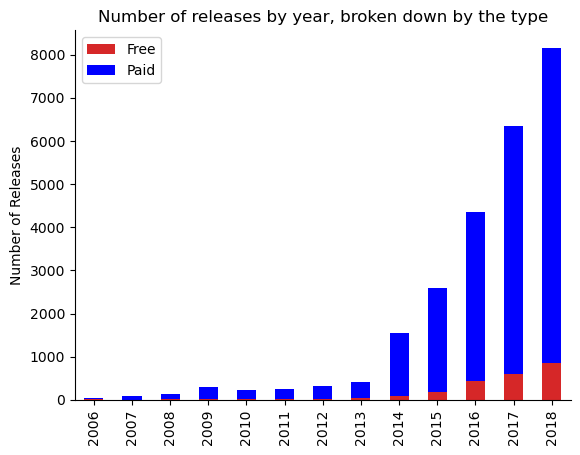

In [25]:
# Release per Year
df = pDF.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.type == "Free"].shape[0]
    total_gt_20k = year_df[year_df.type == "Paid"].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Free', 'Paid'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'blue'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by the type')
sns.despine()
plt.show()

In [26]:
#df = topPDF.copy()
#df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)
#topPDF.sort_values(by='total_playtime',ascending=False)

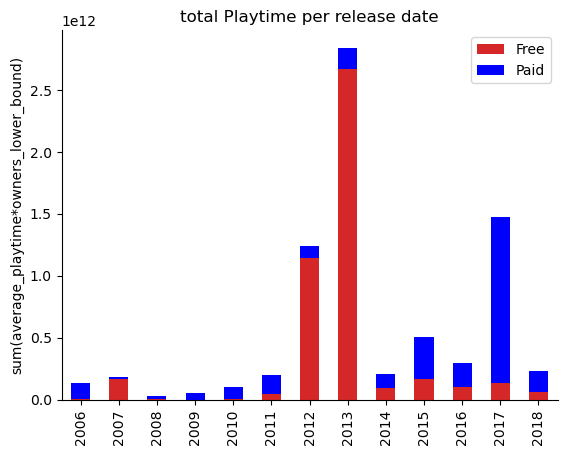

In [27]:
# Playtime ( sum(average_playtime*owners_lower_bound) ) per Year
df = pDF.copy()

#df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.type == "Free"]['total_playtime'].sum()
    total_gt_20k = year_df[year_df.type == "Paid"]['total_playtime'].sum()
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Free', 'Paid'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'blue'])

ax.set_xlabel('')
ax.set_ylabel('sum(average_playtime*owners_lower_bound)')
ax.set_title('total Playtime per release date')
sns.despine()
plt.show()

### Aussage

Es gibt ein paar Spiele die extrem populär sind und mehr spielzeit generieren als tausende andere spiele zusammen.


FREE 0.6140612525625283
PAID 0.3859387474374717


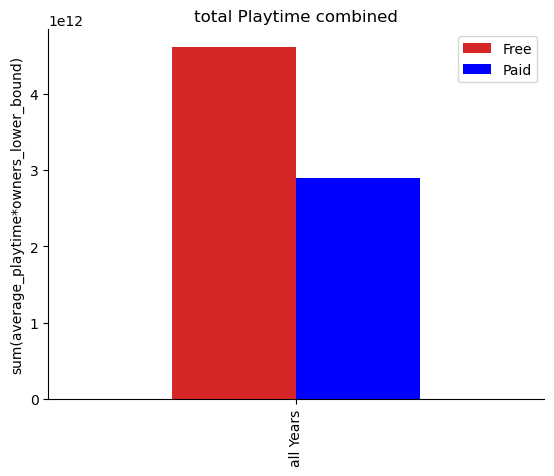

In [28]:
# Playtime ( sum(average_playtime*owners_lower_bound) ) per Year
df = pDF.copy()

#df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.type == "Free"]['total_playtime'].sum()
    total_gt_20k = year_df[year_df.type == "Paid"]['total_playtime'].sum()
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
    
years = ['all Years']
gesamtlt = np.sum(lt_20k)
gesamtgt = np.sum(gt_20k)

gesamtGesamt = gesamtlt + gesamtgt

print("FREE",gesamtlt / gesamtGesamt)
print("PAID",gesamtgt / gesamtGesamt)


owners_df = pd.DataFrame(zip(years, [gesamtlt], [gesamtgt]), 
                         columns=['year', 'Free', 'Paid'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=False, color=['tab:red', 'blue'])

ax.set_xlabel('')
ax.set_ylabel('sum(average_playtime*owners_lower_bound)')
ax.set_title('total Playtime combined')
sns.despine()
plt.show()

In [52]:
pDF.sort_values(by='total_playtime',ascending=False).head(20)

,appid,name,release_date,english,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,captions_available,co_op,commentary_available,cross_platform_multiplayer,full_controller_support,in_app_purchases,includes_source_sdk,includes_level_editor,local_co_op,local_multi_player,mmo,mods,mods_require_hl2,multi_player,online_co_op,online_multi_player,partial_controller_support,shared_split_screen,single_player,stats,steam_achievements,steam_cloud,steam_leaderboards,steam_trading_cards,steam_turn_notifications,steam_workshop,steamvr_collectibles,vr_support,valve_anti_cheat_enabled,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,top_tag,type,total_playtime,estimated_revenue
22,570,Dota 2,2013-07-09,1,Valve,Valve,0,Action;Free to Play;Strategy,0,863507,142079,23944,801,0.00,100000000,200000000,1005586,0.858710,85.201281,2013,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Free to Play,Free,2394400000000,0.000000e+00
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,PUBG Corporation,PUBG Corporation,0,Action;Adventure;Massively Multiplayer,37,496184,487076,22938,12434,26.99,50000000,100000000,983260,0.504632,50.066901,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Survival,Paid,1146900000000,1.349500e+09
25,730,Counter-Strike: Global Offensive,2012-08-21,1,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,2644404,402313,22494,6502,0.00,50000000,100000000,3046717,0.867952,86.310312,2012,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FPS,Free,1124700000000,0.000000e+00
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Action,0,124534,3339,17612,317,7.19,10000000,20000000,127873,0.973888,95.975678,2000,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Paid,176120000000,7.190000e+07
19,440,Team Fortress 2,2007-10-10,1,Valve,Valve,0,Action;Free to Play,520,515879,34036,8495,623,0.00,20000000,50000000,549915,0.938107,92.933233,2007,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Free to Play,Free,169900000000,0.000000e+00
121,4000,Garry's Mod,2006-11-29,1,Facepunch Studios,Valve,0,Indie;Simulation,29,363721,16433,12422,1875,6.99,10000000,20000000,380154,0.956773,94.677179,2006,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Sandbox,Paid,124220000000,6.990000e+07
1634,230410,Warframe,2013-03-25,1,Digital Extremes,Digital Extremes,16,Action;Free to Play,187,226541,20268,5845,394,0.00,20000000,50000000,246809,0.917880,90.695302,2013,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Free to Play,Free,116900000000,0.000000e+00
2478,271590,Grand Theft Auto V,2015-04-13,1,Rockstar North,Rockstar Games,18,Action;Adventure,77,329061,139308,9837,4834,24.99,10000000,20000000,468369,0.702568,69.567115,2015,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Open World,Paid,98370000000,2.499000e+08
1025,72850,The Elder Scrolls V: Skyrim,2011-11-10,1,Bethesda Game Studios,Bethesda Softworks,16,RPG,75,237303,14951,7089,3885,9.99,10000000,20000000,252254,0.940730,92.960488,2011,0,0,1,0,0,0,0,0

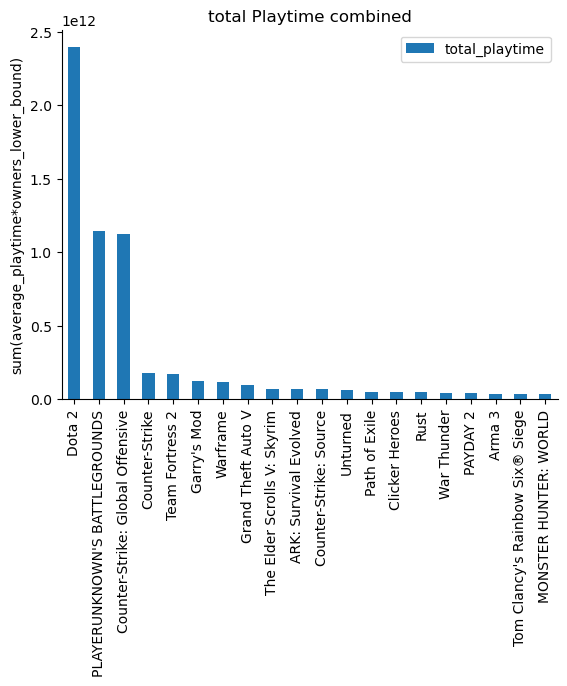

In [30]:
data = pDF.sort_values(by='total_playtime',ascending=False).head(20)

ax = data.plot(x='name', y='total_playtime', kind='bar', stacked=False)
ax.set_xlabel('')
ax.set_ylabel('sum(average_playtime*owners_lower_bound)')
ax.set_title('total Playtime combined')
sns.despine()
plt.show()

In [31]:
top3Playtime = pDF.sort_values(by='total_playtime',ascending=False).head(3)[('total_playtime')].sum()
allOtherPlaytime = pDF.sort_values(by='total_playtime',ascending=True).head((27075-3))[('total_playtime')].sum()

totalPlaytimeAll = pDF['total_playtime'].sum()
print("top3Playtime:",top3Playtime*100/totalPlaytimeAll)
print("allOtherPlaytime:",allOtherPlaytime*100/totalPlaytimeAll)



top3Playtime: 59.700122624768376
allOtherPlaytime: 40.299877375231624


## Insight 2

In [55]:
tptPDF = pDF.sort_values('total_playtime',ascending=False).head(math.ceil(27075*0.01))
tptPDF

,appid,name,release_date,english,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,captions_available,co_op,commentary_available,cross_platform_multiplayer,full_controller_support,in_app_purchases,includes_source_sdk,includes_level_editor,local_co_op,local_multi_player,mmo,mods,mods_require_hl2,multi_player,online_co_op,online_multi_player,partial_controller_support,shared_split_screen,single_player,stats,steam_achievements,steam_cloud,steam_leaderboards,steam_trading_cards,steam_turn_notifications,steam_workshop,steamvr_collectibles,vr_support,valve_anti_cheat_enabled,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,top_tag,type,total_playtime,estimated_revenue
22,570,Dota 2,2013-07-09,1,Valve,Valve,0,Action;Free to Play;Strategy,0,863507,142079,23944,801,0.00,100000000,200000000,1005586,0.858710,85.201281,2013,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Free to Play,Free,2394400000000,0.000000e+00
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,PUBG Corporation,PUBG Corporation,0,Action;Adventure;Massively Multiplayer,37,496184,487076,22938,12434,26.99,50000000,100000000,983260,0.504632,50.066901,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Survival,Paid,1146900000000,1.349500e+09
25,730,Counter-Strike: Global Offensive,2012-08-21,1,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,2644404,402313,22494,6502,0.00,50000000,100000000,3046717,0.867952,86.310312,2012,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FPS,Free,1124700000000,0.000000e+00
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Action,0,124534,3339,17612,317,7.19,10000000,20000000,127873,0.973888,95.975678,2000,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Paid,176120000000,7.190000e+07
19,440,Team Fortress 2,2007-10-10,1,Valve,Valve,0,Action;Free to Play,520,515879,34036,8495,623,0.00,20000000,50000000,549915,0.938107,92.933233,2007,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Free to Play,Free,169900000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,391540,Undertale,2015-09-15,1,tobyfox,tobyfox,0,Indie;RPG,0,97832,4496,679,443,6.99,2000000,5000000,102328,0.956063,94.122755,2015,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Great Soundtrack,Paid,1358000000,1.398000e+07
5553,367500,Dragon's Dogma: Dark Arisen,2016-01-15,1,Capcom,Capcom,0,Action;Adventure;RPG,59,12856,1688,1355,1137,23.99,1000000,2000000,14544,0.883938,85.926151,2016,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,RPG,Paid,1355000000,2.399000e+07
1773,239030,"Papers, Please",2013-08-08,1,Lucas Pope,3909,0,Adventure;Indie,13,25587,1103,674,214,6.99,2000000,5000000,26690,0.958674,93.638047,2013,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,

In [38]:
pDF.sort_values(by='estimated_revenue',ascending=False).head(20)

,appid,name,release_date,english,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,captions_available,co_op,commentary_available,cross_platform_multiplayer,full_controller_support,in_app_purchases,includes_source_sdk,includes_level_editor,local_co_op,local_multi_player,mmo,mods,mods_require_hl2,multi_player,online_co_op,online_multi_player,partial_controller_support,shared_split_screen,single_player,stats,steam_achievements,steam_cloud,steam_leaderboards,steam_trading_cards,steam_turn_notifications,steam_workshop,steamvr_collectibles,vr_support,valve_anti_cheat_enabled,accounting,action,adventure,animation_and_modeling,audio_production,casual,design_and_illustration,documentary,early_access,education,free_to_play,game_development,gore,indie,massively_multiplayer,nudity,photo_editing,rpg,racing,sexual_content,simulation,software_training,sports,strategy,tutorial,utilities,video_production,violent,web_publishing,top_tag,type,total_playtime,estimated_revenue
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,PUBG Corporation,PUBG Corporation,0,Action;Adventure;Massively Multiplayer,37,496184,487076,22938,12434,26.99,50000000,100000000,983260,0.504632,50.066901,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Survival,Paid,1146900000000,1.349500e+09
12965,582010,MONSTER HUNTER: WORLD,2018-08-09,1,"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.",0,Action,50,72029,35294,6512,5372,49.99,5000000,10000000,107323,0.671142,66.087643,2018,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Action,Paid,32560000000,2.499500e+08
2478,271590,Grand Theft Auto V,2015-04-13,1,Rockstar North,Rockstar Games,18,Action;Adventure,77,329061,139308,9837,4834,24.99,10000000,20000000,468369,0.702568,69.567115,2015,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Open World,Paid,98370000000,2.499000e+08
4712,346110,ARK: Survival Evolved,2017-08-27,1,Studio Wildcard;Instinct Games;Efecto Studios;...,Studio Wildcard,0,Action;Adventure;Indie;Massively Multiplayer;RPG,32,145035,66603,14154,1470,44.99,5000000,10000000,211638,0.685298,67.675307,2017,1,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Survival,Paid,70770000000,2.249500e+08
22458,863550,HITMAN™ 2,2018-11-13,1,IO Interactive A/S,Warner Bros Interactive Entertainment,0,Action,125,10814,1756,636,514,44.99,5000000,10000000,12570,0.860302,83.520727,2018,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Stealth,Paid,3180000000,2.249500e+08
2016,252490,Rust,2018-02-08,1,Facepunch Studios,Facepunch Studios,18,Action;Adventure;Indie;Massively Multiplayer;RPG,48,220370,53709,9352,2234,27.79,5000000,10000000,274079,0.804038,79.476392,2018,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Survival,Paid,46760000000,1.389500e+08
2964,292030,The Witcher® 3: Wild Hunt,2015-05-18,1,CD PROJEKT RED,CD PROJEKT RED,0,RPG,78,202930,4798,3068,2002,24.99,5000000,10000000,207728,0.976902,96.465364,2015,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Open World,Paid,15340000000,1.249500e+08
2087,255710,Cities: Skylines,2015-03-10,1,Colossal Order Ltd.,Paradox Interactive,0,Simulation;Strategy,97,67553,6005,3225,444,22.99,5000000,10000000,73558,0.918364,90.262459,2015,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,City Builder,Paid,16125000000,1.149500e+08
2878,289070,Sid Meier’s Civ

Text(0.5, 1.0, 'Combination total_playtime,rating ')

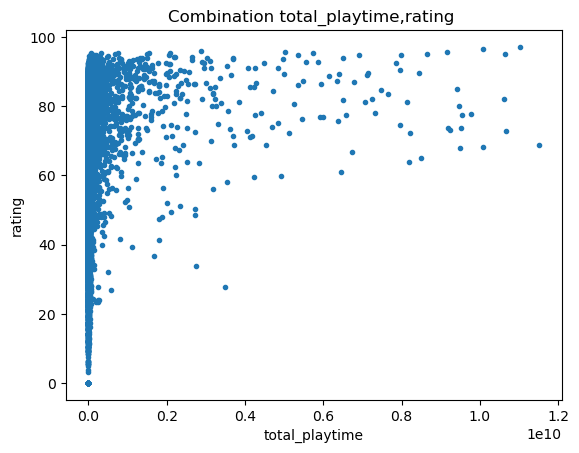

In [47]:
xCol = 'total_playtime'
yCol = 'rating' 

#data = pDF.sort_values(by='estimated_revenue',ascending=False).head(1)
data = topPDF.sort_values(by='total_playtime',ascending=True).head(len(topPDF.index)-50)

color =  np.array(['red','blue'])
plt.scatter(marker='.',x=data[xCol],y=data[yCol])
plt.xlabel(xCol)
plt.ylabel(yCol)
plt.title('Combination '+xCol+','+yCol +' ')

In [51]:
pDF[['total_playtime','type']]

,total_playtime,type
0,176120000000,Paid
1,1385000000,Paid
2,935000000,Paid
3,1290000000,Paid
4,3120000000,Paid
...,...,...
27070,0,Paid
27071,0,Paid
27072,0,Paid
27073,0,Paid


In [ ]:
# IDEE:Scatter plot mit ratings * playtime rank, color: Playtime Gruppen (top 25,50, ...)
# je besser das rating desto höher ist das rating 